In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdm as sdm

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')
spec = "human"
ST_name = "breastcancer5fold"
seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
rna_adata = sc.read_mtx("../../data/scRNAseq/BreastCancer/matrix.mtx.gz").T
rna_adata.var_names = pd.read_csv("../../data/scRNAseq/BreastCancer/features.tsv", header=None).iloc[:, 0].values
rna_adata.obs_names = pd.read_csv("../../data/scRNAseq/BreastCancer/barcodes.tsv", header=None).iloc[:, 0].values

def validate_genes():
    from pyensembl import EnsemblRelease

    # release 77 uses human reference genome GRCh38
    data = EnsemblRelease(108)
    res = []
    valid_ids = []
    counter = 0
    for gid in rna_adata.var_names:
        try:
            name = data.gene_name_of_gene_id(gid)
            if len(name) == 0:
                raise Exception("None name")
            res.append(name)
            valid_ids.append(gid)
        except Exception as e:
            counter += 1
            
    print(f"Missed genes {counter}")    
    return res, valid_ids
gene_names, valid_ids = validate_genes()
rna_adata = rna_adata[:, valid_ids].copy()
rna_adata.var_names = gene_names
ids, cts = np.unique(rna_adata.var_names, return_counts=True)
deduplicated = [id for id,ct in zip(ids,cts) if ct==1]
rna_adata.var_names_make_unique()
rna_adata = rna_adata[:, deduplicated]

spa_adata = sc.read_mtx("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/matrix.mtx").T
spa_adata.var_names = pd.read_csv("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/features.tsv", header=None).iloc[:, 0].values
spa_adata.obs_names = pd.read_csv("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/barcodes.tsv", header=None).iloc[:, 0].values
df_obs = pd.read_csv("../../data/ST/BreastCancer/metadata/1142243F_metadata.csv", header=0, index_col=0)
spa_adata.obs = df_obs.loc[spa_adata.obs_names]
df_loc = pd.read_csv("../../data/ST/BreastCancer/spatial/1142243F_spatial/tissue_positions_list.csv", header=None, index_col=0).loc[spa_adata.obs_names]
spa_adata.obs['In_tissue'] = df_loc.iloc[:, 0]
spa_adata.obs['array_row'] = df_loc.iloc[:, 1]
spa_adata.obs['array_col'] = df_loc.iloc[:, 2]
spa_adata.obs['px_row'] = df_loc.iloc[:, 3]
spa_adata.obs['px_col'] = df_loc.iloc[:, 4]
# sc.pp.normalize_total(rna_adata)
# sc.pp.log1p(rna_adata)
spa_adata.obsm['spatial'] = spa_adata.obs[['px_row', 'px_col']].values
pd.DataFrame(spa_adata.obsm['spatial'], columns=['x','y']).to_csv(f"../../output/locations/{ST_name}.csv", index=False)

rna_adata, spa_adata

Missed genes 12593


(View of AnnData object with n_obs × n_vars = 35276 × 33745,
 AnnData object with n_obs × n_vars = 4784 × 28402
     obs: 'nCount_RNA', 'nFeature_RNA', 'patientid', 'subtype', 'Classification', 'In_tissue', 'array_row', 'array_col', 'px_row', 'px_col'
     obsm: 'spatial')

In [3]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sq.gr.spatial_neighbors(spa_adata, coord_type="grid", n_neighs=6)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)

sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.normalize_total(spa_adata)
sc.pp.log1p(spa_adata)

sc.pp.filter_genes(rna_adata, min_cells=30)
sc.pp.filter_genes(spa_adata, min_cells=3)
# sc.pp.highly_variable_genes(rna_adata, n_top_genes=10000)
# rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()

sc.pp.highly_variable_genes(spa_adata, n_top_genes=5000)
sdm.extract_lr(spa_adata, spec, min_cell=0)
spa_genes = set()
for pair in spa_adata.uns['geneInter'].interaction_name:
    _genes = pair.split('_')
    for g in _genes:
        for _g in g.split(":"):
            spa_genes.add(_g)
for gene in spa_adata.uns['moranI'].index[spa_adata.uns['moranI'].pval_norm_fdr_bh <= 0.01].values:
    spa_genes.add(gene)
for gene in spa_adata.var_names[spa_adata.var.highly_variable]:    
    spa_genes.add(gene)

print(len(np.intersect1d(list(spa_genes), spa_adata.var_names)), len(spa_genes), spa_adata.n_vars)
spa_adata = spa_adata[:, np.intersect1d(list(spa_genes), spa_adata.var_names)]
rna_adata, spa_adata

5435 5477 20722


(AnnData object with n_obs × n_vars = 35276 × 22830
     obs: 'leiden'
     var: 'n_cells'
     uns: 'log1p',
 View of AnnData object with n_obs × n_vars = 4784 × 5435
     obs: 'nCount_RNA', 'nFeature_RNA', 'patientid', 'subtype', 'Classification', 'In_tissue', 'array_row', 'array_col', 'px_row', 'px_col'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial_neighbors', 'moranI', 'log1p', 'hvg', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter'
     obsm: 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [4]:
raw_spatial_df  = pd.DataFrame(spa_adata.X.toarray(), columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X.toarray(), columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((4784, 5435), (35276, 22830), (4241,))

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        n_epochs=2000,
        # clip_max=0.5,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

    df_transImpCls[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

    df_transImp[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                # clip_max=0.5,
                n_epochs=2000,
                seed=seed,
                device=device)
    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "8984798460", top_k=2000, verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
      np.median(corr_transImp_res), "(TransImp)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
      )
      


===== Fold 1 =====
Number of train genes: 3392, Number of test genes: 849


[TransImp] Epoch: 2000/2000, loss: 0.994901, (IMP) 0.993717, (SPA) 1.0 x 0.001184: 100%|██████████| 2000/2000 [00:43<00:00, 45.73it/s]


Median correlation: 0.029820056917339244 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.092744, (IMP) 1.092744, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:13<00:00, 149.89it/s]


Median correlation: 0.0660586607349438 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.982530, (IMP) 0.982530, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:33<00:00, 59.22it/s]


Median correlation: 0.043728369688301474 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.096826, (IMP) 1.094284, (SPA) 1.0 x 0.002542: 100%|██████████| 2000/2000 [00:22<00:00, 88.62it/s]


Median correlation: 0.055171858432839865 (TransImpClsSpa)
			nan (stPlus)
			0.01965093974536625 (spaGE)


INFO:root:3392 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3392 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3392 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.293, KL reg: 0.035
Score: 0.331, KL reg: 0.000
Score: 0.332, KL reg: 0.000
Score: 0.332, KL reg: 0.000
Score: 0.332, KL reg: 0.000
Score: 0.332, KL reg: 0.000
Score: 0.332, KL reg: 0.000
Score: 0.332, KL reg: 0.000
Score: 0.332, KL reg: 0.000
Score: 0.332, KL reg: 0.000


INFO:root:Saving results..


			0.06300814323287812 (Tangram)

===== Fold 2 =====
Number of train genes: 3393, Number of test genes: 848


[TransImp] Epoch: 2000/2000, loss: 0.991074, (IMP) 0.989897, (SPA) 1.0 x 0.001177: 100%|██████████| 2000/2000 [00:43<00:00, 46.26it/s]


Median correlation: 0.03052339608291115 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.085912, (IMP) 1.085912, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:13<00:00, 149.02it/s]


Median correlation: 0.06220901025009637 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.978957, (IMP) 0.978957, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:34<00:00, 58.56it/s]


Median correlation: 0.04221472767356474 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.089984, (IMP) 1.087453, (SPA) 1.0 x 0.002531: 100%|██████████| 2000/2000 [00:22<00:00, 87.95it/s]


Median correlation: 0.05217396602160815 (TransImpClsSpa)
			nan (stPlus)
			0.01905950941369918 (spaGE)


INFO:root:3393 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3393 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3393 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.293, KL reg: 0.035
Score: 0.332, KL reg: 0.000
Score: 0.332, KL reg: 0.000
Score: 0.332, KL reg: 0.000
Score: 0.333, KL reg: 0.000
Score: 0.333, KL reg: 0.000
Score: 0.333, KL reg: 0.000
Score: 0.333, KL reg: 0.000
Score: 0.333, KL reg: 0.000
Score: 0.333, KL reg: 0.000


INFO:root:Saving results..


			0.058858276954616484 (Tangram)

===== Fold 3 =====
Number of train genes: 3393, Number of test genes: 848


[TransImp] Epoch: 2000/2000, loss: 1.001036, (IMP) 1.000041, (SPA) 1.0 x 0.000995: 100%|██████████| 2000/2000 [00:43<00:00, 45.96it/s]


Median correlation: 0.03146012295179197 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.097251, (IMP) 1.097251, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:13<00:00, 148.14it/s]


Median correlation: 0.07261850057708122 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.987998, (IMP) 0.987998, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:34<00:00, 58.28it/s]


Median correlation: 0.049160096969381256 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.101075, (IMP) 1.098801, (SPA) 1.0 x 0.002274: 100%|██████████| 2000/2000 [00:22<00:00, 87.92it/s]


Median correlation: 0.058751234283641554 (TransImpClsSpa)
			nan (stPlus)
			0.020098714302246717 (spaGE)


INFO:root:3393 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3393 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3393 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.292, KL reg: 0.035
Score: 0.330, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000


INFO:root:Saving results..


			0.06490571656456784 (Tangram)

===== Fold 4 =====
Number of train genes: 3393, Number of test genes: 848


[TransImp] Epoch: 2000/2000, loss: 0.996816, (IMP) 0.995674, (SPA) 1.0 x 0.001142: 100%|██████████| 2000/2000 [00:43<00:00, 46.08it/s]


Median correlation: 0.03186880765917312 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.091895, (IMP) 1.091895, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:13<00:00, 148.87it/s]


Median correlation: 0.06644793313997437 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.983904, (IMP) 0.983904, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:34<00:00, 58.29it/s]


Median correlation: 0.047351657257831956 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.095864, (IMP) 1.093539, (SPA) 1.0 x 0.002325: 100%|██████████| 2000/2000 [00:22<00:00, 87.33it/s]


Median correlation: 0.05471136007144328 (TransImpClsSpa)
			nan (stPlus)
			0.020694784491499526 (spaGE)


INFO:root:3393 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3393 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3393 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.292, KL reg: 0.035
Score: 0.330, KL reg: 0.000
Score: 0.330, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000
Score: 0.331, KL reg: 0.000


INFO:root:Saving results..


			0.061458308843319966 (Tangram)

===== Fold 5 =====
Number of train genes: 3393, Number of test genes: 848


[TransImp] Epoch: 2000/2000, loss: 1.000118, (IMP) 0.998963, (SPA) 1.0 x 0.001155: 100%|██████████| 2000/2000 [00:43<00:00, 46.03it/s]


Median correlation: 0.032620400338683284 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.097179, (IMP) 1.097179, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:13<00:00, 148.07it/s]


Median correlation: 0.07114935855371396 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.988471, (IMP) 0.988471, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:34<00:00, 58.18it/s]


Median correlation: 0.04957565159948933 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.101227, (IMP) 1.098680, (SPA) 1.0 x 0.002547: 100%|██████████| 2000/2000 [00:22<00:00, 87.38it/s]


Median correlation: 0.0583949240907568 (TransImpClsSpa)
			nan (stPlus)
			0.021454602085081736 (spaGE)


INFO:root:3393 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3393 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3393 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.291, KL reg: 0.035
Score: 0.329, KL reg: 0.000
Score: 0.329, KL reg: 0.000
Score: 0.330, KL reg: 0.000
Score: 0.330, KL reg: 0.000
Score: 0.330, KL reg: 0.000
Score: 0.330, KL reg: 0.000
Score: 0.330, KL reg: 0.000
Score: 0.330, KL reg: 0.000
Score: 0.330, KL reg: 0.000


INFO:root:Saving results..


			0.06333848222888114 (Tangram)
0.031237268549318135 (TransImpSpa) 0.046399128491815454 (TransImp) 0.06763785995192416 (TransImpCls) 0.05611388135091896 (TransImpClsSpa) nan (stPlus) 0.0201071736191129 (spaGE) 0.06251274779981494 (Tangram)


In [6]:
df_transImp.to_csv(f'../../output/{ST_name}_{ST_name}_TransImp.csv')
df_transImpSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv')
df_transImpCls.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv')
df_transImpClsSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv')
df_spaGE_res.to_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv')
df_stplus_res.to_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv')
df_tangram_res.to_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv')
raw_spatial_df[raw_shared_gene].to_csv(f'../../output/{ST_name}_{ST_name}_truth.csv')


In [7]:
dict_df = {
            "TransImp":df_transImp, 
           "TransImpSpa":df_transImpSpa, 
           "TransImpCls":df_transImpCls,
           "TransImpClsSpa":df_transImpClsSpa,
           "spaGE": df_spaGE_res, 
           "stPlus": df_stplus_res,
            "Tangram":df_tangram_res,
            "truth":raw_spatial_df[raw_shared_gene].copy(),
            }
spa_adata.X = spa_adata.X.toarray()
sq.gr.spatial_autocorr(
    spa_adata,
    genes=spa_adata.var_names,
    n_jobs=10,
)

dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}


In [8]:
from sklearn.metrics import mean_squared_error
moranIs = {name:mean_squared_error(spa_adata.uns['moranI'].loc[raw_shared_gene].I, imp_adata.uns['moranI'].loc[raw_shared_gene].I) for name, imp_adata in dict_adata.items() if name != 'stPlus'}

print("Mean Squared Error\nMoran's I:\n")
print("\n".join([f"\tTrue vs {method}: {score:.6f}" for method, score in moranIs.items()]))



Mean Squared Error
Moran's I:

	True vs TransImp: 0.066343
	True vs TransImpSpa: 0.002952
	True vs TransImpCls: 0.135111
	True vs TransImpClsSpa: 0.002734
	True vs spaGE: 0.010240
	True vs Tangram: 0.057577
	True vs truth: 0.000000


In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings

color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
methods = ['truth', 'Tangram', 'TransImp', 'TransImpSpa', 'spaGE', 'stPlus',  'TransImpCls', 'TransImpClsSpa']
warnings.filterwarnings('ignore')

eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01

In [10]:
if is_reeval:
    df_spa = dict_df['truth']
    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'fdr':{}, 'I':{}, 'pval':{}}
    for method  in tqdm(methods):
        
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            genes=imp_adata.var_names,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue
        
        fdr = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['fdr'][method] = pd.Series(fdr, df_res.columns)
        eval_res['pval'][method] = pd.Series(imp_adata.uns['moranI'].pval_norm, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)

100%|██████████| 8/8 [01:03<00:00,  7.94s/it]


In [11]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

imp_adatas = dict(sorted(imp_adatas.items()))
df_fdr

Tangram  TransImp  TransImpCls  TransImpClsSpa  TransImpSpa  \
A1BG-AS1  0.000000  0.000000     0.000000        0.000000     0.000000   
A2M       0.000000  0.000000     0.000000        0.000000     0.000000   
A2M-AS1   0.000000  0.000000     0.000000        0.000000     0.000000   
A4GALT    0.000000  0.000000     0.000000        0.000000     0.000000   
AAMP      0.000000  0.000000     0.000000        0.000000     0.000000   
...            ...       ...          ...             ...          ...   
ZSWIM8    0.284202  0.241324     0.381100        0.009945     0.000639   
ZWILCH    0.349547  0.216766     0.404805        0.006402     0.000564   
ZWINT     0.469850  0.185677     0.487083        0.001107     0.000269   
ZXDA      0.442882  0.171673     0.413342        0.000671     0.000019   
ZXDB      0.319530  0.090099     0.232462        0.000029     0.000002   

             spaGE  stPlus     truth  
A1BG-AS1  0.000000     NaN  0.137034  
A2M       0.000000     NaN  0.000000  
A2M-AS1   0.000000     NaN  0.272979  
A4GALT    0.000000     NaN  0.494320  
AAMP      0.000000     NaN  0.000001  
...            ...     ...       ...  
ZSWIM8    0.042221     NaN  0.494320  
ZWILCH    0.038828     NaN  0.494320  
ZWINT     0.024853     NaN  0.083282  
ZXDA      0.016589     NaN  0.494320  
ZXDB      0.008853     NaN  0.161919  

[4241 rows x 8 columns]

(Tangram) Valid genes: 3010/4241
0
Tangram
(Tangram) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2985/3010)
FPR: 0.988511
(TransImp) Valid genes: 3010/4241
0
TransImp
(TransImp) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2945/3010)
FPR: 0.970321
(TransImpSpa) Valid genes: 3010/4241
0
TransImpSpa
(TransImpSpa) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (1748/3010)
FPR: 0.552417
(spaGE) Valid genes: 3010/4241
0
spaGE
(spaGE) Valid genes: 3010/4241, Ground Sig/Total (921/3010), Pred Sig/total (2479/3010)
FPR: 0.807085
(stPlus) Valid genes: 3004/4241
3004
stPlus
(stPlus) Valid genes: 3004/4241, Ground Sig/Total (919/3004), Pred Sig/total (0/3004)
FPR: 0.000000


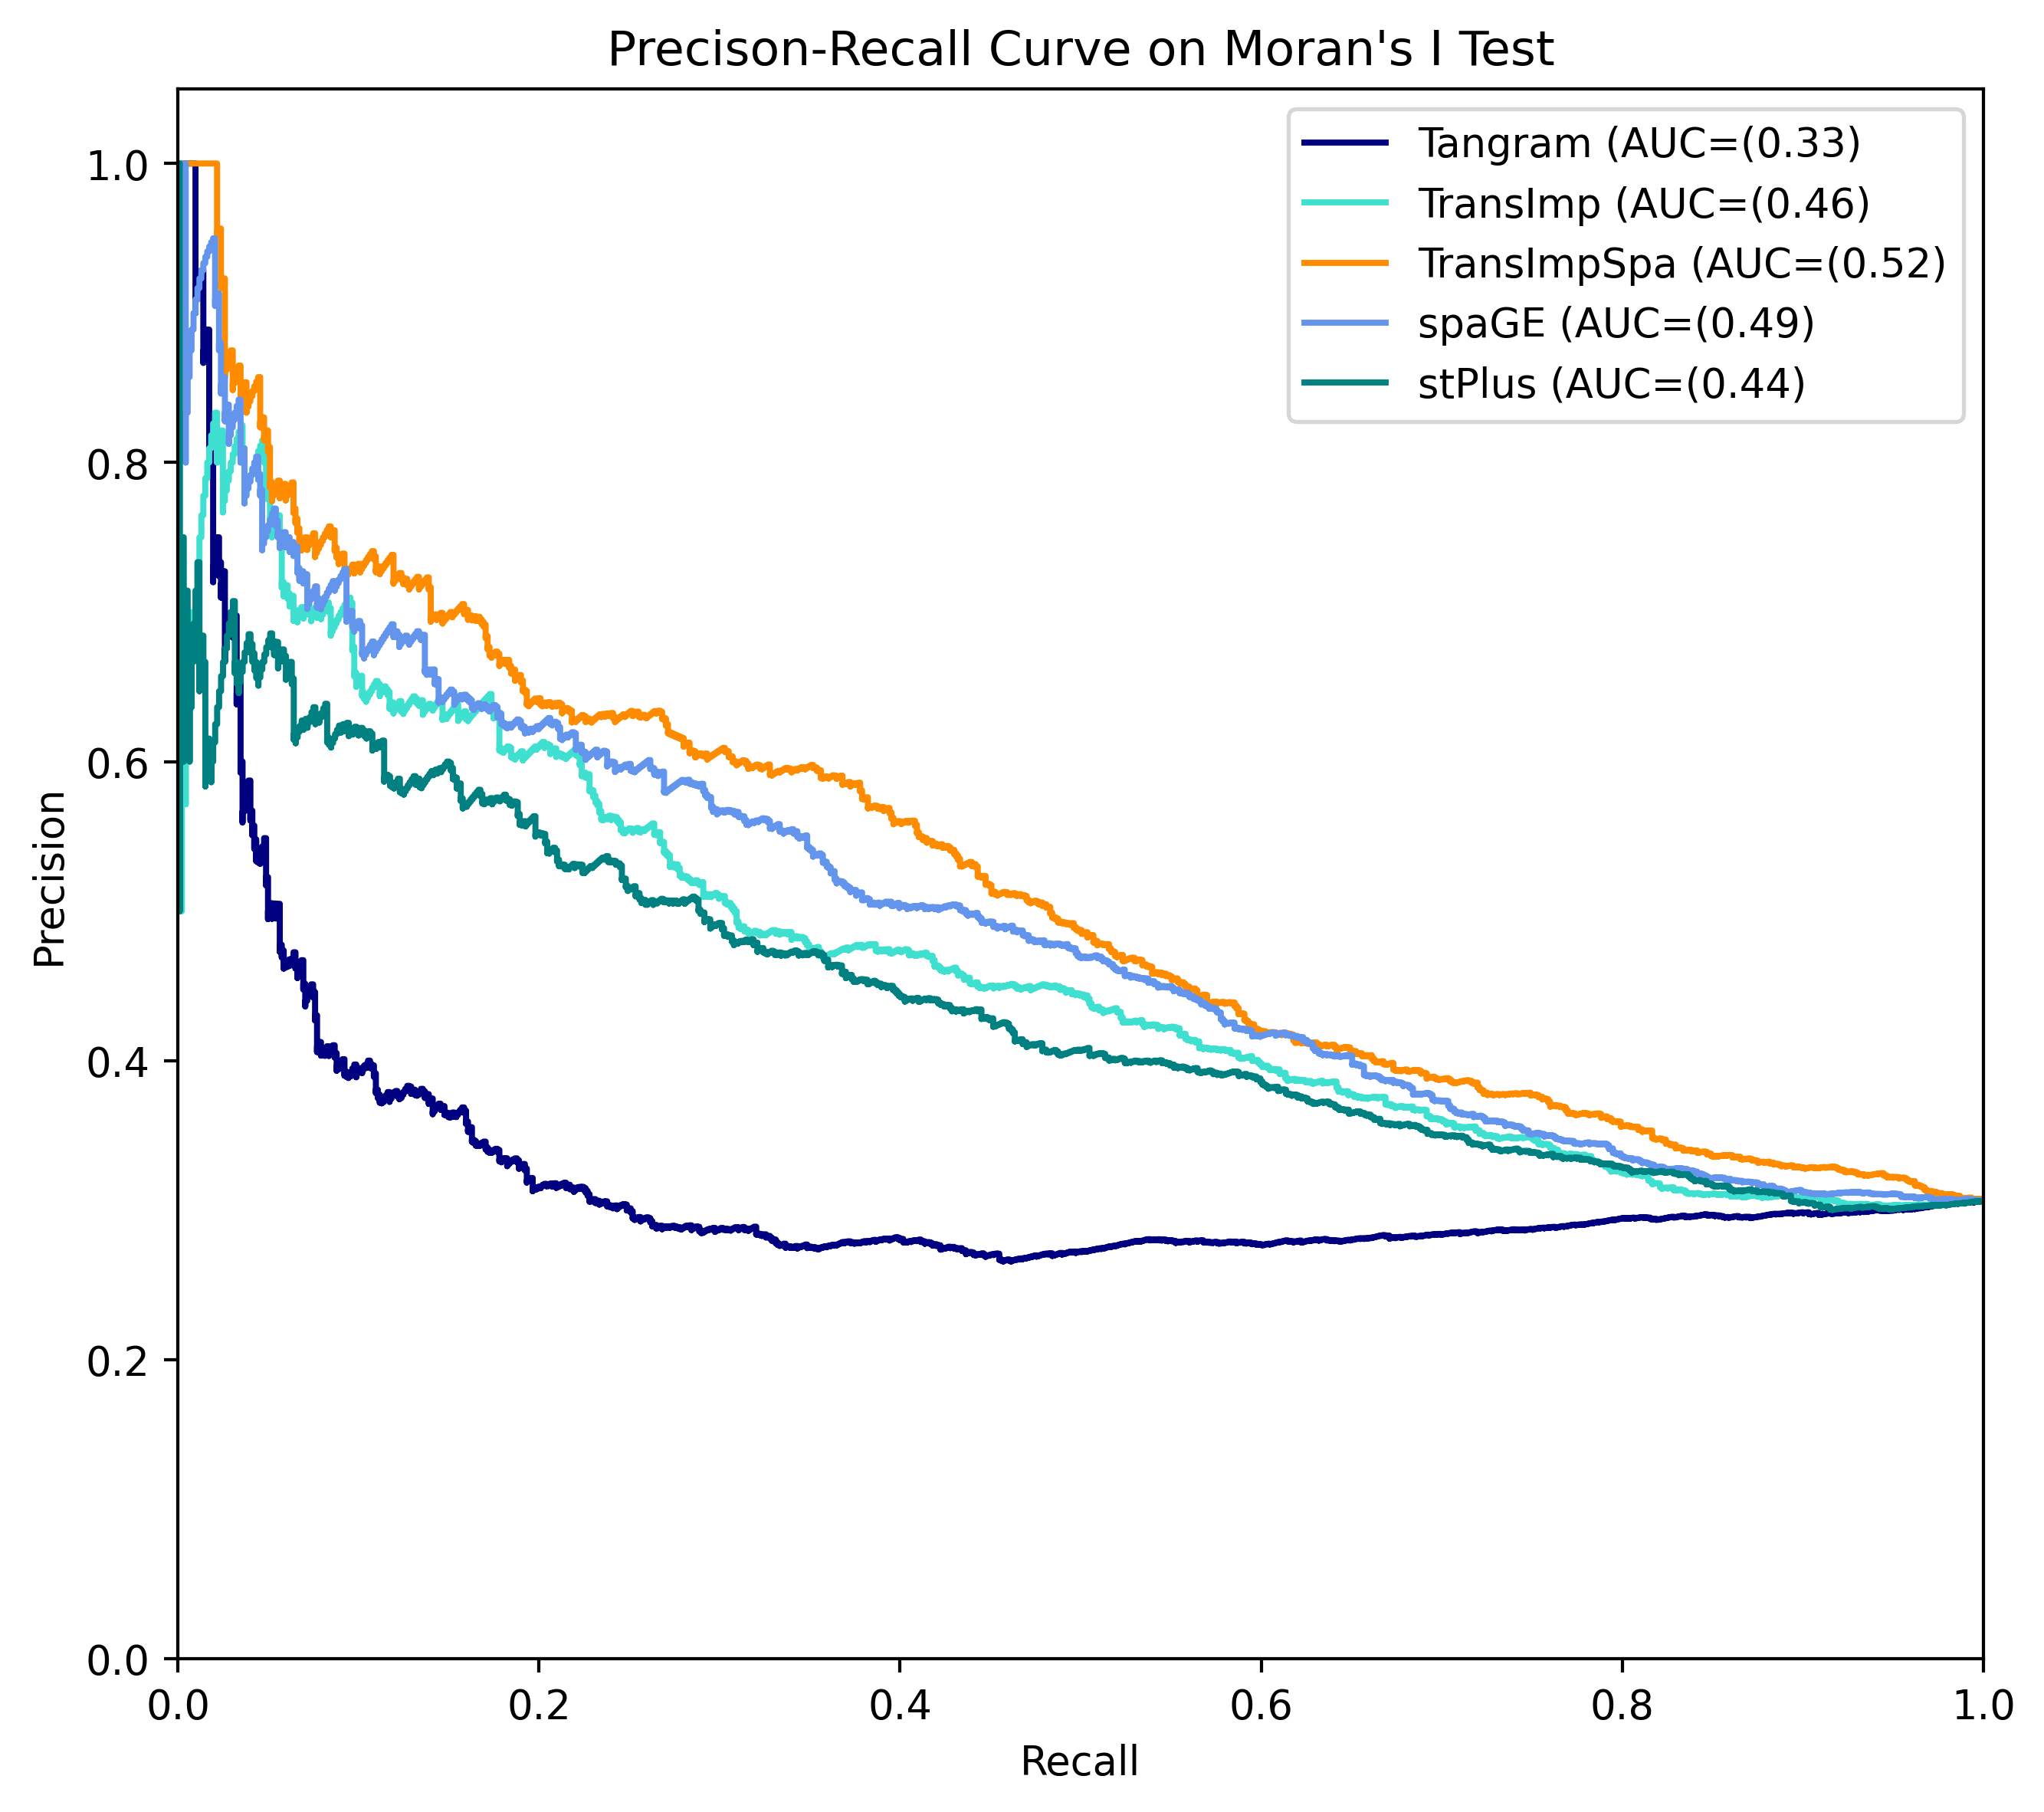

In [12]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, preds_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min()/1e6, 1e-300))
    # score[np.isinf(score)] = score[~np.isinf(score)].max()*10
    print(np.isnan(preds_pval).sum())
    # plt.hist(fdr, bins=100)
    print(method)
    preds = preds_pval < thred
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}, Ground Sig/Total ({(truth_pval < thred).sum()}/{truth_pval.shape[0]}), Pred Sig/total ({(preds_pval < thred).sum()}/{preds_pval.shape[0]})')
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpClsSpa", 'truth'}:
        idx += 1
    else:
        continue     
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 3010/4241
Tangram
FPR: 0.988511
(TransImp) Valid genes: 3010/4241
TransImp
FPR: 0.970321
(TransImpSpa) Valid genes: 3010/4241
TransImpSpa
FPR: 0.552417
(spaGE) Valid genes: 3010/4241
spaGE
FPR: 0.807085
(stPlus) Valid genes: 3004/4241
stPlus
FPR: 0.000000


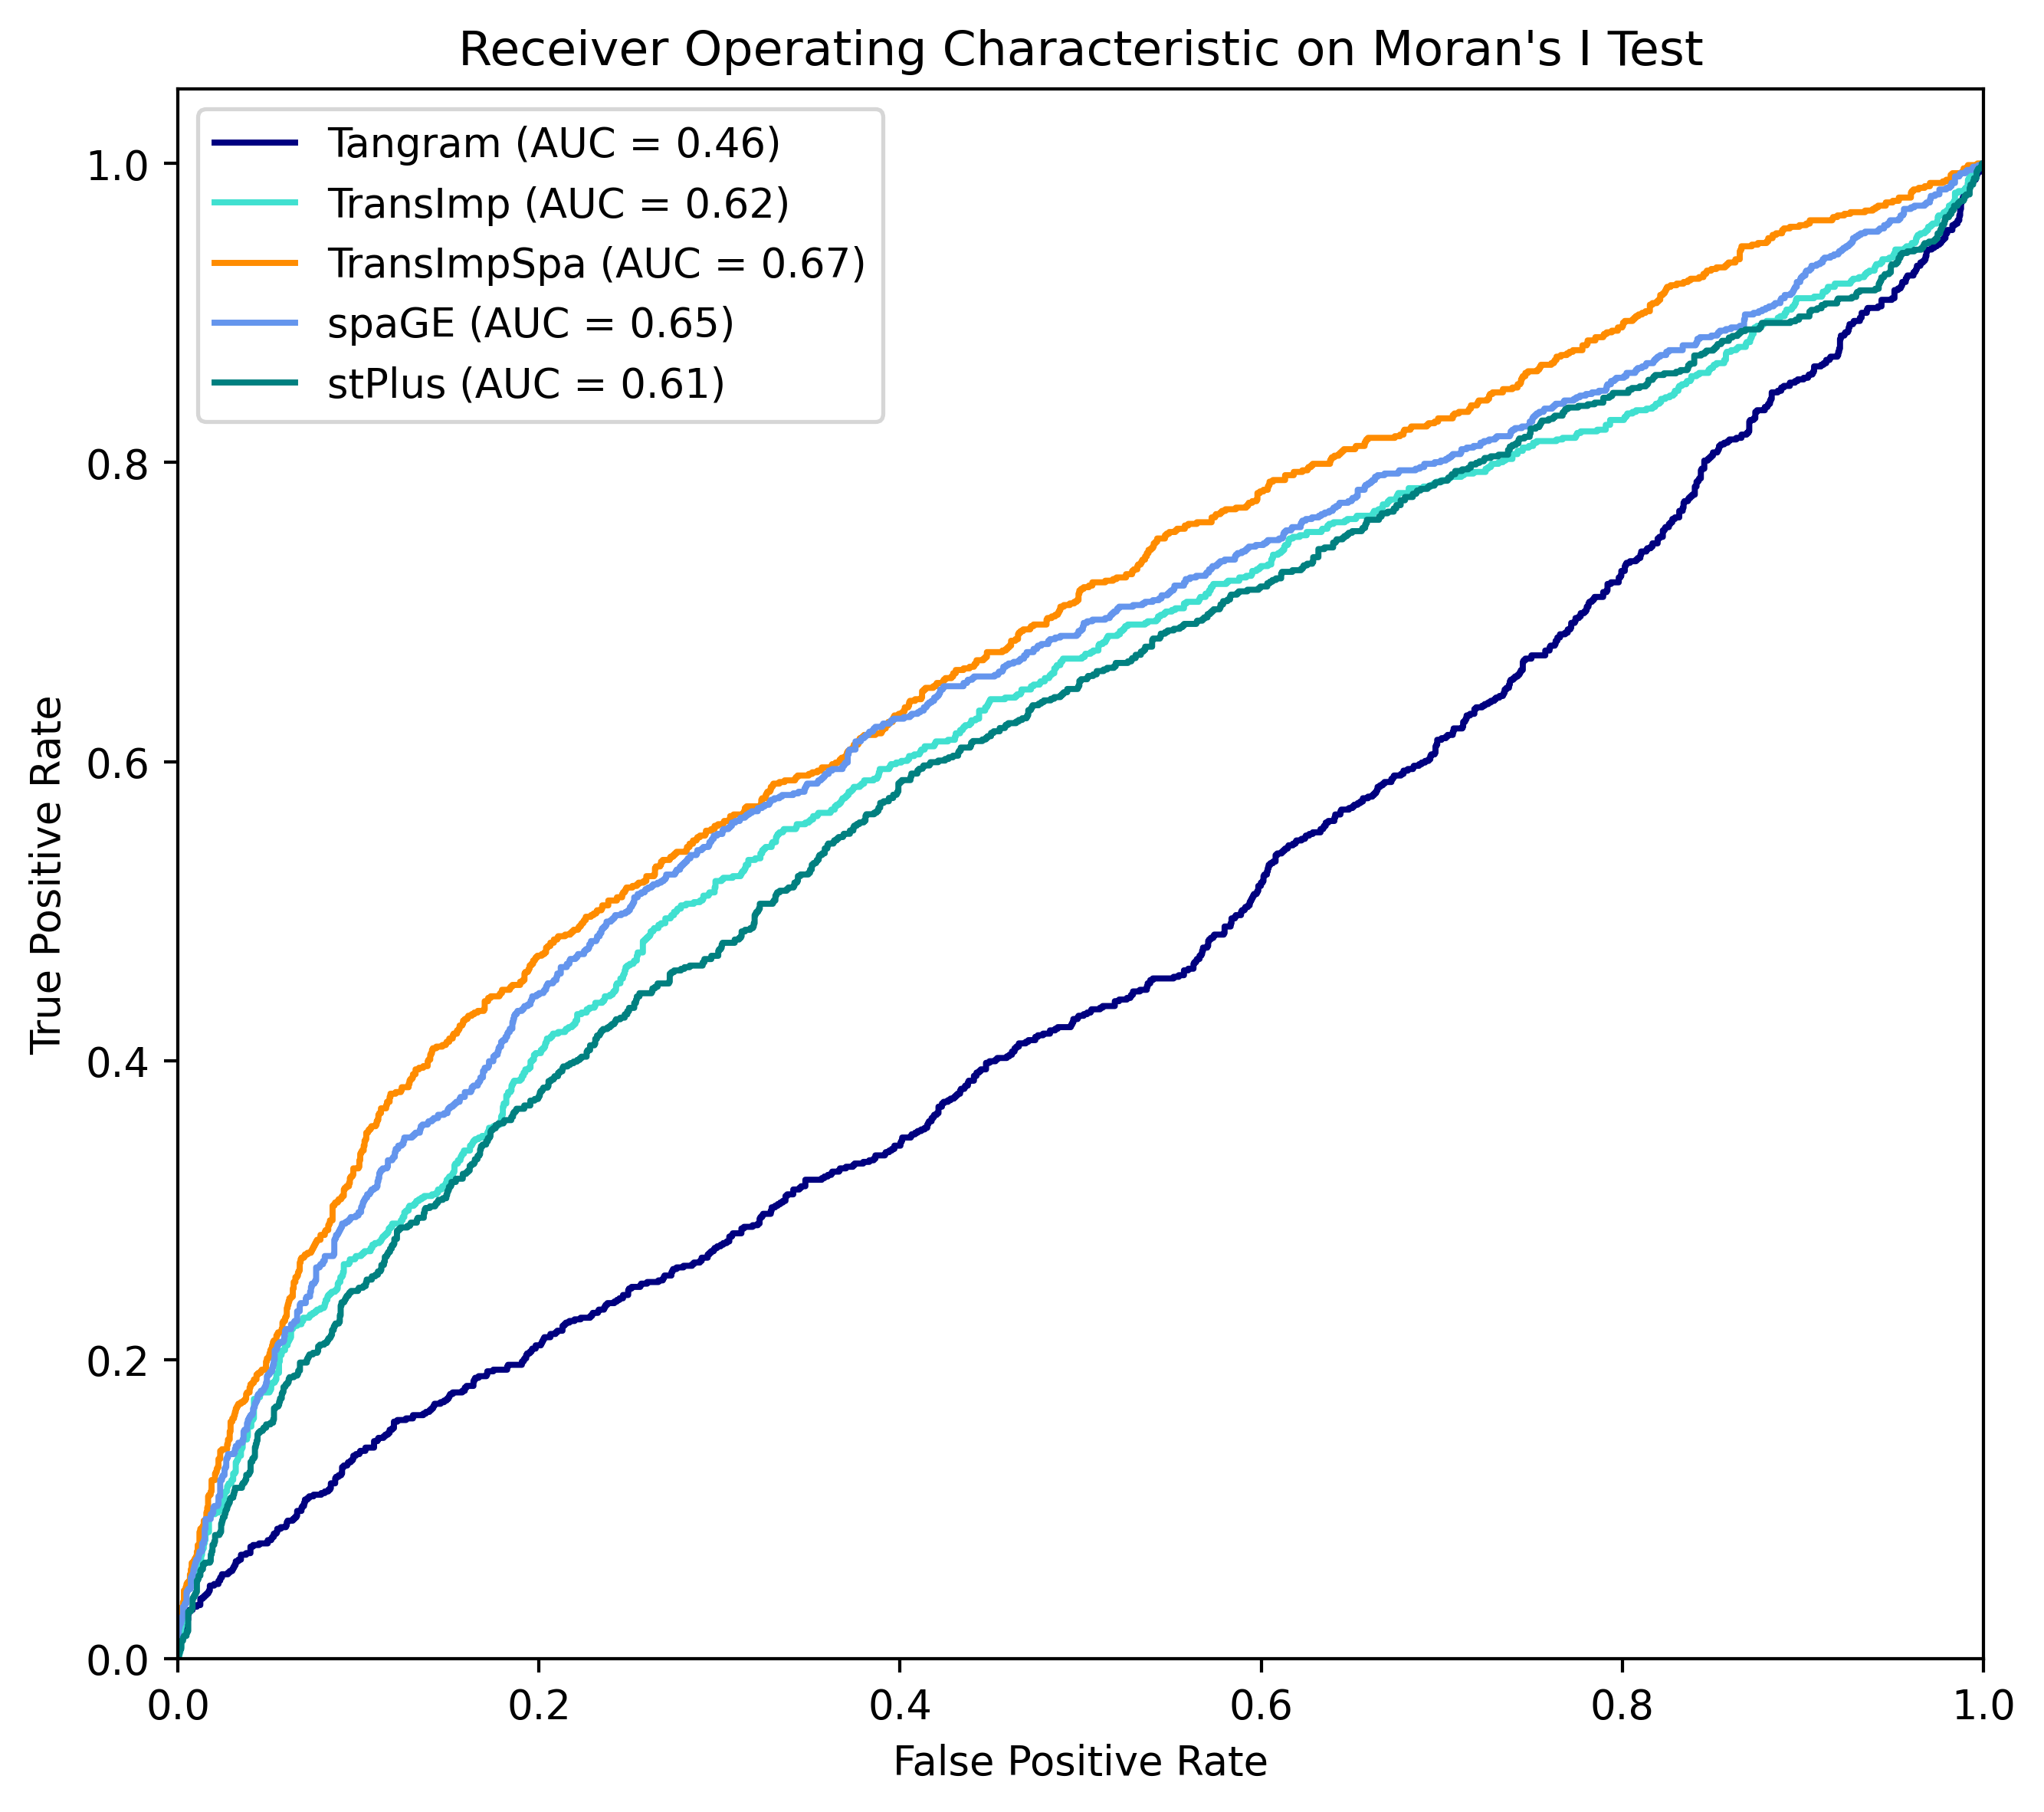

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [13]:
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min()/1e6, 1e-300))
    # score[np.isinf(score)] = score[~np.isinf(score)].max()*10    
    print(method)
    preds = method_pval < thred
    
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    
    if not method in {"transImpCls", 'truth',  "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    
    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 3010/4241
Tangram
FPR: 0.988511
prec: 0.3082077051926298, recl: 0.998914223669924,  F1: 0.4710701484895033
(TransImp) Valid genes: 3010/4241
TransImp
FPR: 0.970321
prec: 0.31171477079796267, recl: 0.996742671009772,  F1: 0.4749094671495086
(TransImpSpa) Valid genes: 3010/4241
TransImpSpa
FPR: 0.552417
prec: 0.33981693363844395, recl: 0.6449511400651465,  F1: 0.4451105282877482
(spaGE) Valid genes: 3010/4241
spaGE
FPR: 0.807085
prec: 0.31988705123033484, recl: 0.8610206297502715,  F1: 0.4664705882352942
(stPlus) Valid genes: 3004/4241
stPlus
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0
(TransImpCls) Valid genes: 3010/4241
TransImpCls
FPR: 0.993777
prec: 0.3073073073073073, recl: 1.0,  F1: 0.47013782542113325
(TransImpClsSpa) Valid genes: 3010/4241
TransImpClsSpa
FPR: 0.539493
prec: 0.3401639344262295, recl: 0.6308360477741585,  F1: 0.44199315329022437


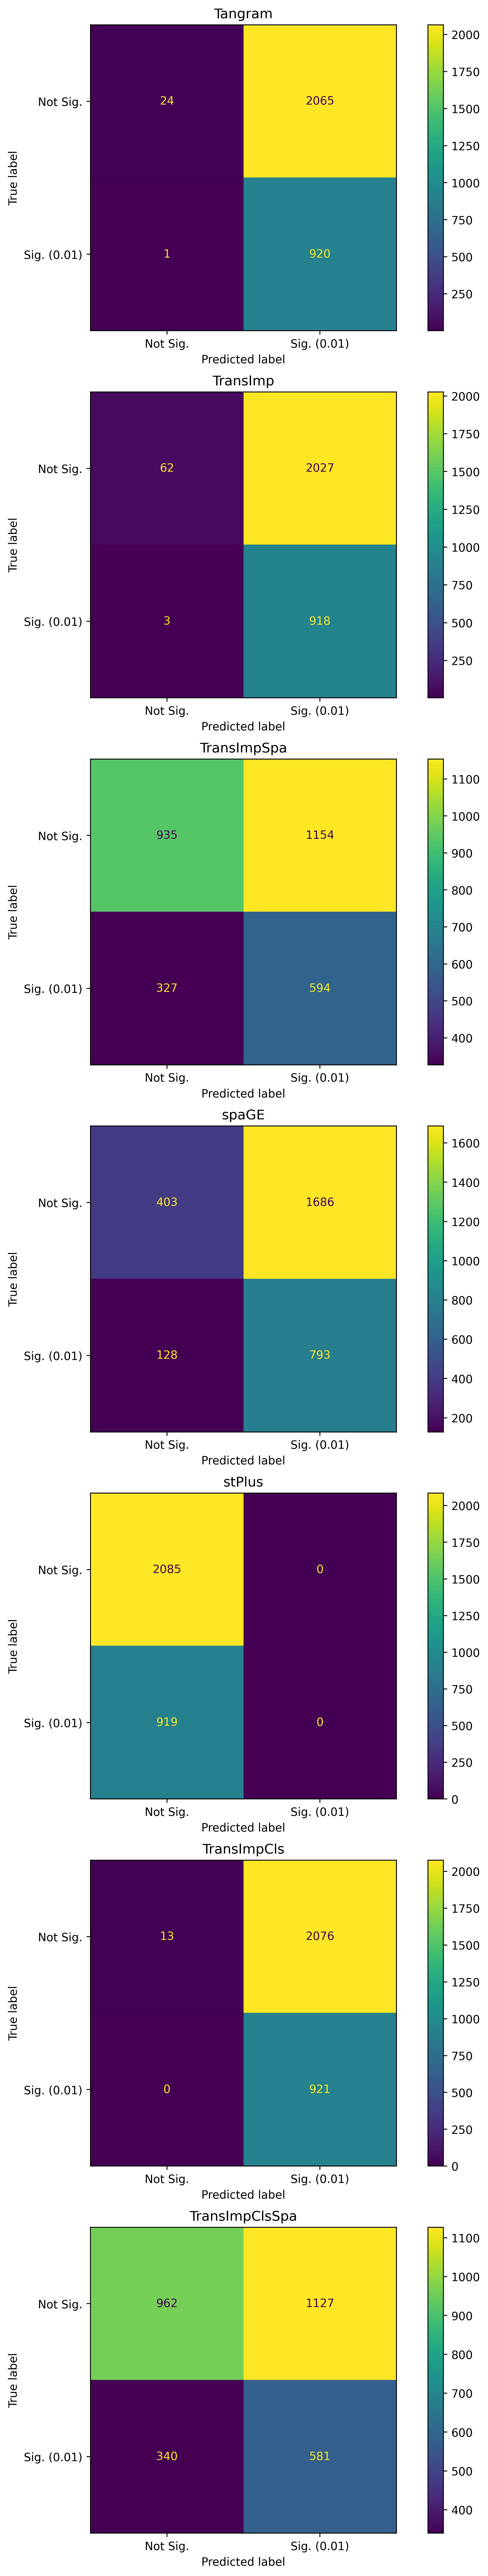

In [14]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in methods:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, pred_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    # score = df_I[method][sel]
    
    print(method)
    preds = pred_pval < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [15]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r breastcancer5fold

[1] "truth"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 4784 
## number of total genes: 4241 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "stPlus"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 4784 
## number of total genes: 4231 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing Wi

In [16]:
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None

for md in methods:
    print(md)
    df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    shared_gene = np.intersect1d(ca_genes, df.index.values)
    if len(shared_gene) < len(ca_genes):
        miss_gene  = np.setdiff1d(ca_genes, shared_gene)
        df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

truth
Tangram
TransImp
TransImpSpa
spaGE
stPlus
TransImpCls
TransImpClsSpa


(                  truth       Tangram      TransImp   TransImpSpa  \
 A1BG.AS1   1.870103e-01  2.774558e-12  7.176686e-08  3.590514e-04   
 A2M       2.865294e-102  3.116680e-39  1.637381e-72  4.818768e-22   
 A2M.AS1    4.318638e-01  1.318358e-10  1.756881e-04  4.372231e-10   
 A4GALT     2.474958e-01  8.429032e-57  8.546635e-58  4.637571e-36   
 AAMP       7.413048e-04  1.102949e-77  1.280978e-49  4.857059e-20   
 ...                 ...           ...           ...           ...   
 ZSWIM8     8.057075e-01  6.448005e-51  7.820907e-24  1.570202e-04   
 ZWILCH     7.588720e-01  2.699856e-66  9.051790e-33  9.550632e-09   
 ZWINT      1.129801e-02  1.439224e-40  5.740859e-43  5.839773e-14   
 ZXDA       2.062807e-01  2.890832e-11  7.771561e-16  2.105686e-06   
 ZXDB       3.656170e-01  2.415717e-44  1.800646e-74  3.239548e-07   
 
                  spaGE        stPlus    TransImpCls  TransImpClsSpa  
 A1BG.AS1  6.154557e-01  3.979652e-07   1.422063e-68    1.458941e-23  
 A2M       1.048

(Tangram) Valid genes: 4241/4241
Tangram
FPR: 0.985989
(TransImp) Valid genes: 4241/4241
TransImp
FPR: 0.958260
(TransImpSpa) Valid genes: 4241/4241
TransImpSpa
FPR: 0.903678
(spaGE) Valid genes: 4241/4241
spaGE
FPR: 0.706947
(stPlus) Valid genes: 4241/4241
stPlus
FPR: 0.950963


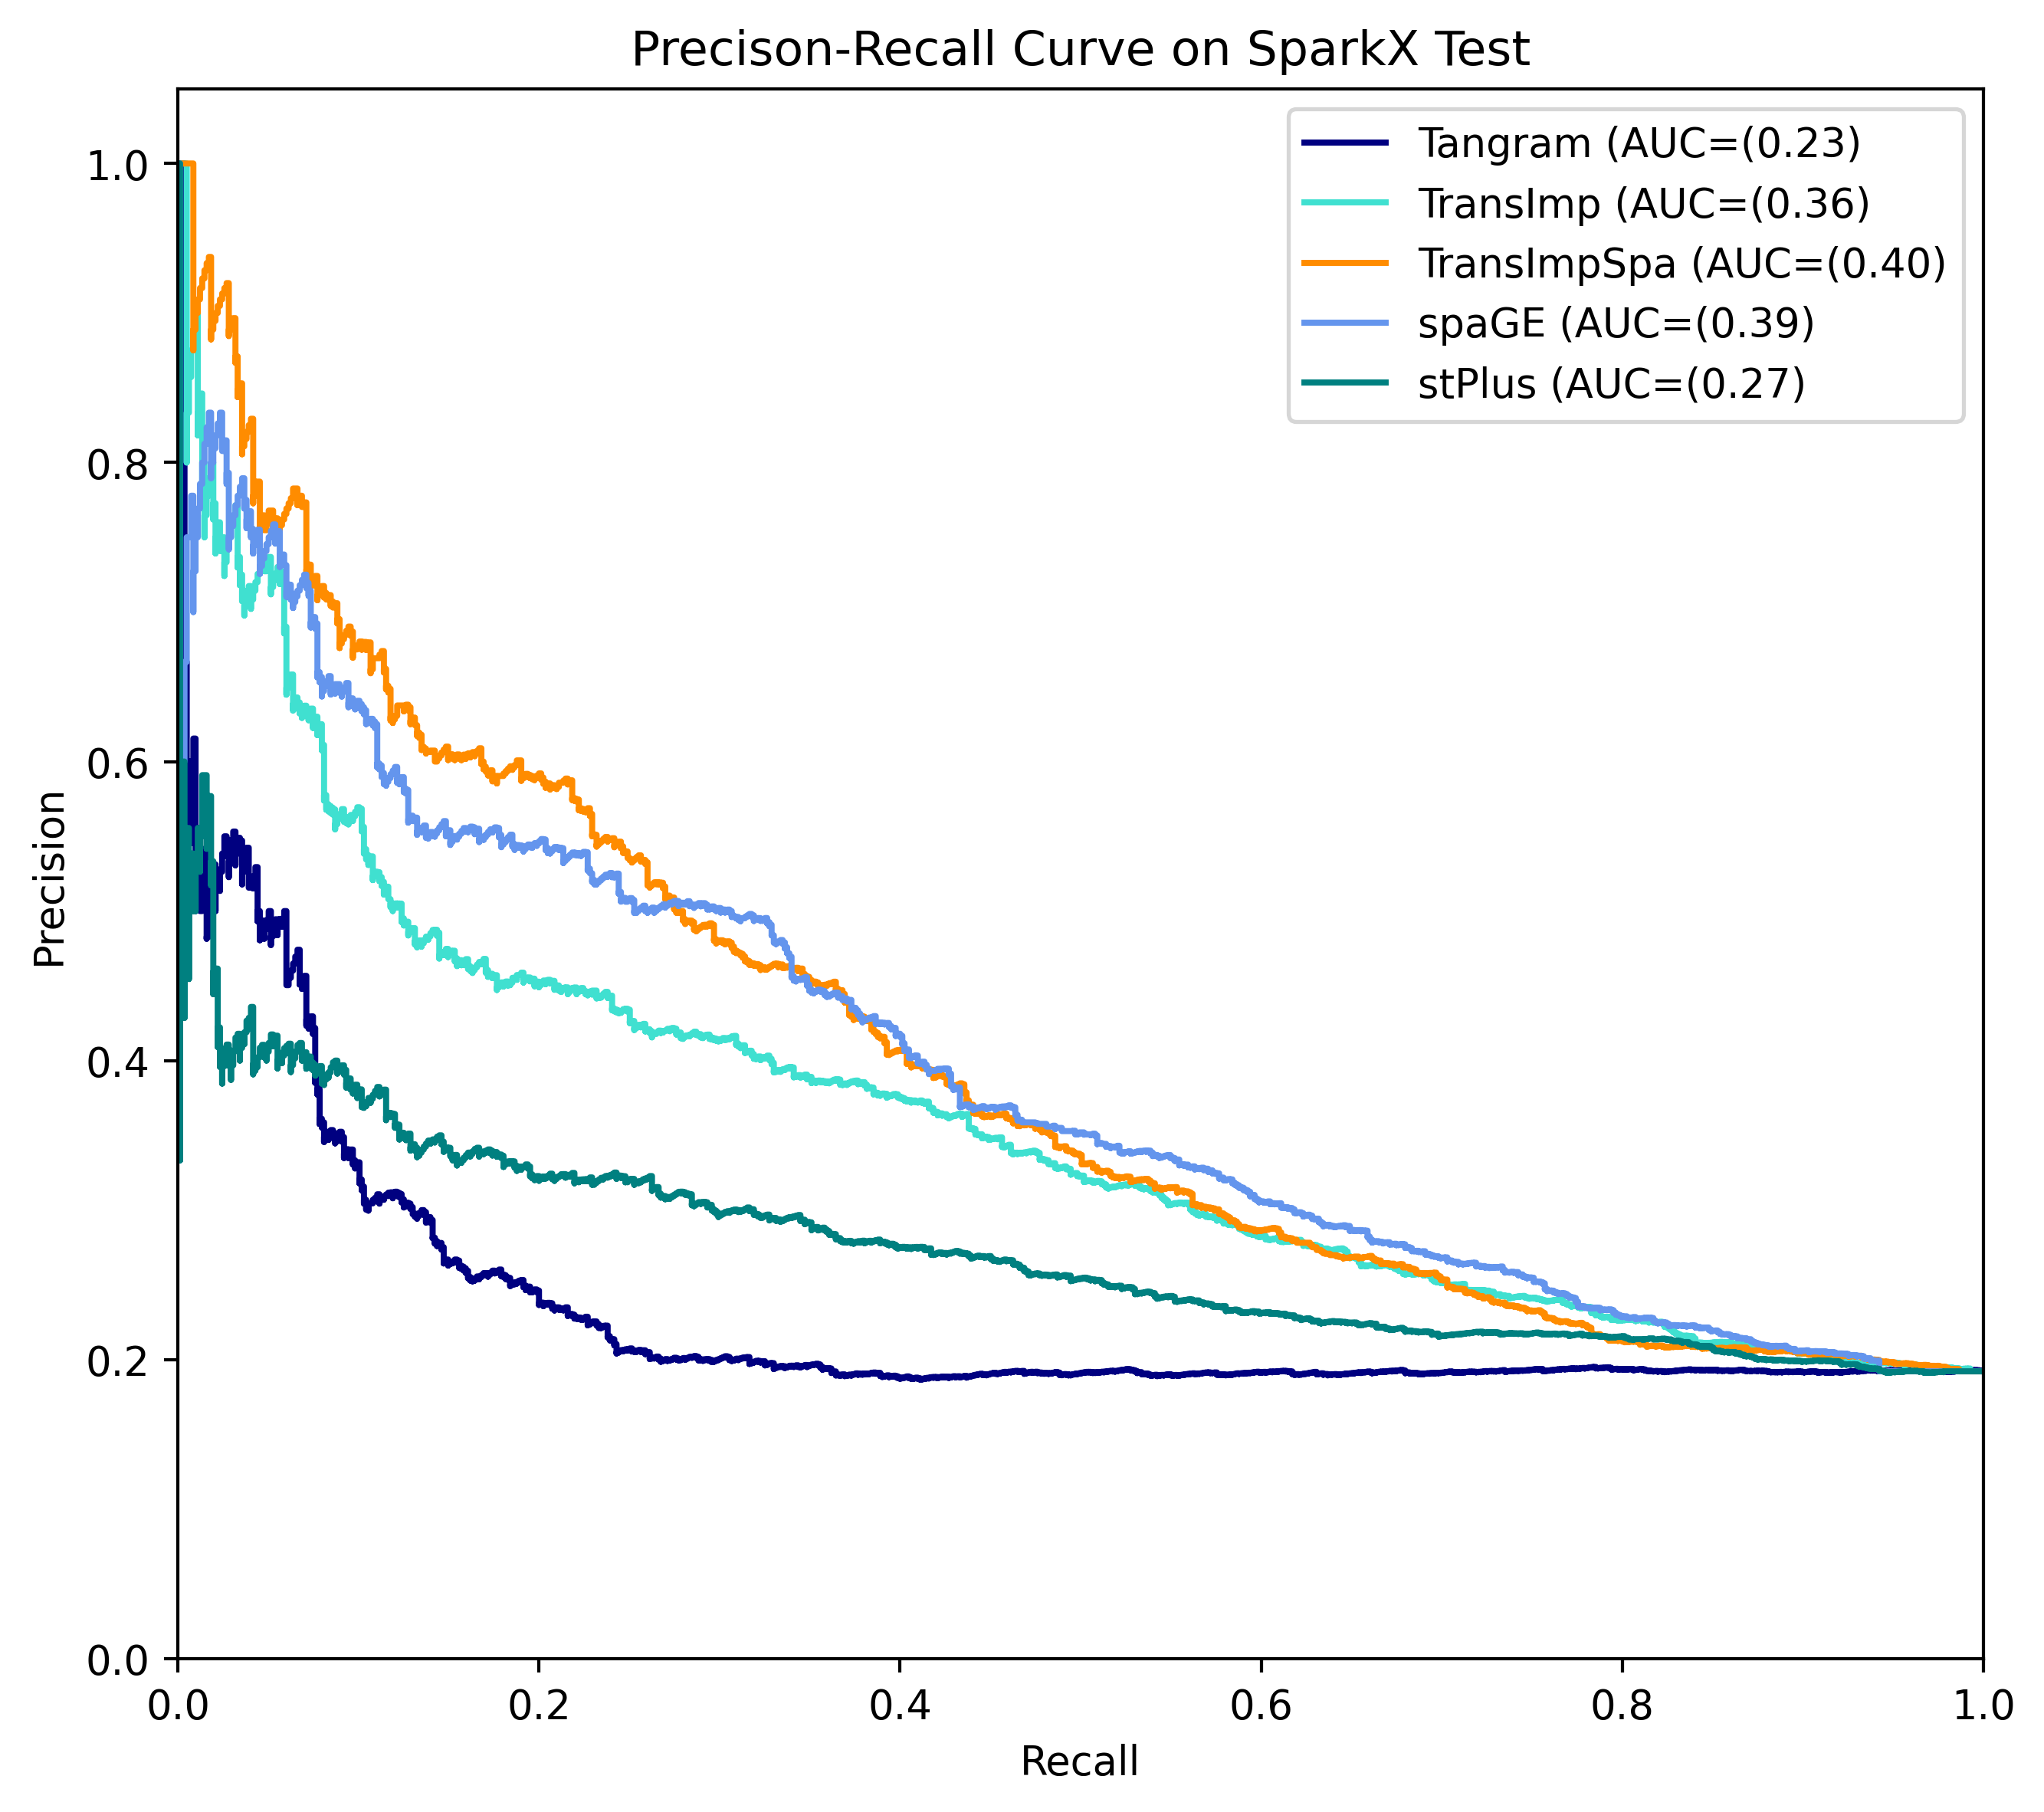

In [17]:
from sklearn import metrics
from matplotlib import pyplot as plt

thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
    
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
       
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 4241/4241
Tangram
FPR: 0.985989
(TransImp) Valid genes: 4241/4241
TransImp
FPR: 0.958260
(TransImpSpa) Valid genes: 4241/4241
TransImpSpa
FPR: 0.903678
(spaGE) Valid genes: 4241/4241
spaGE
FPR: 0.706947
(stPlus) Valid genes: 4241/4241
stPlus
FPR: 0.950963


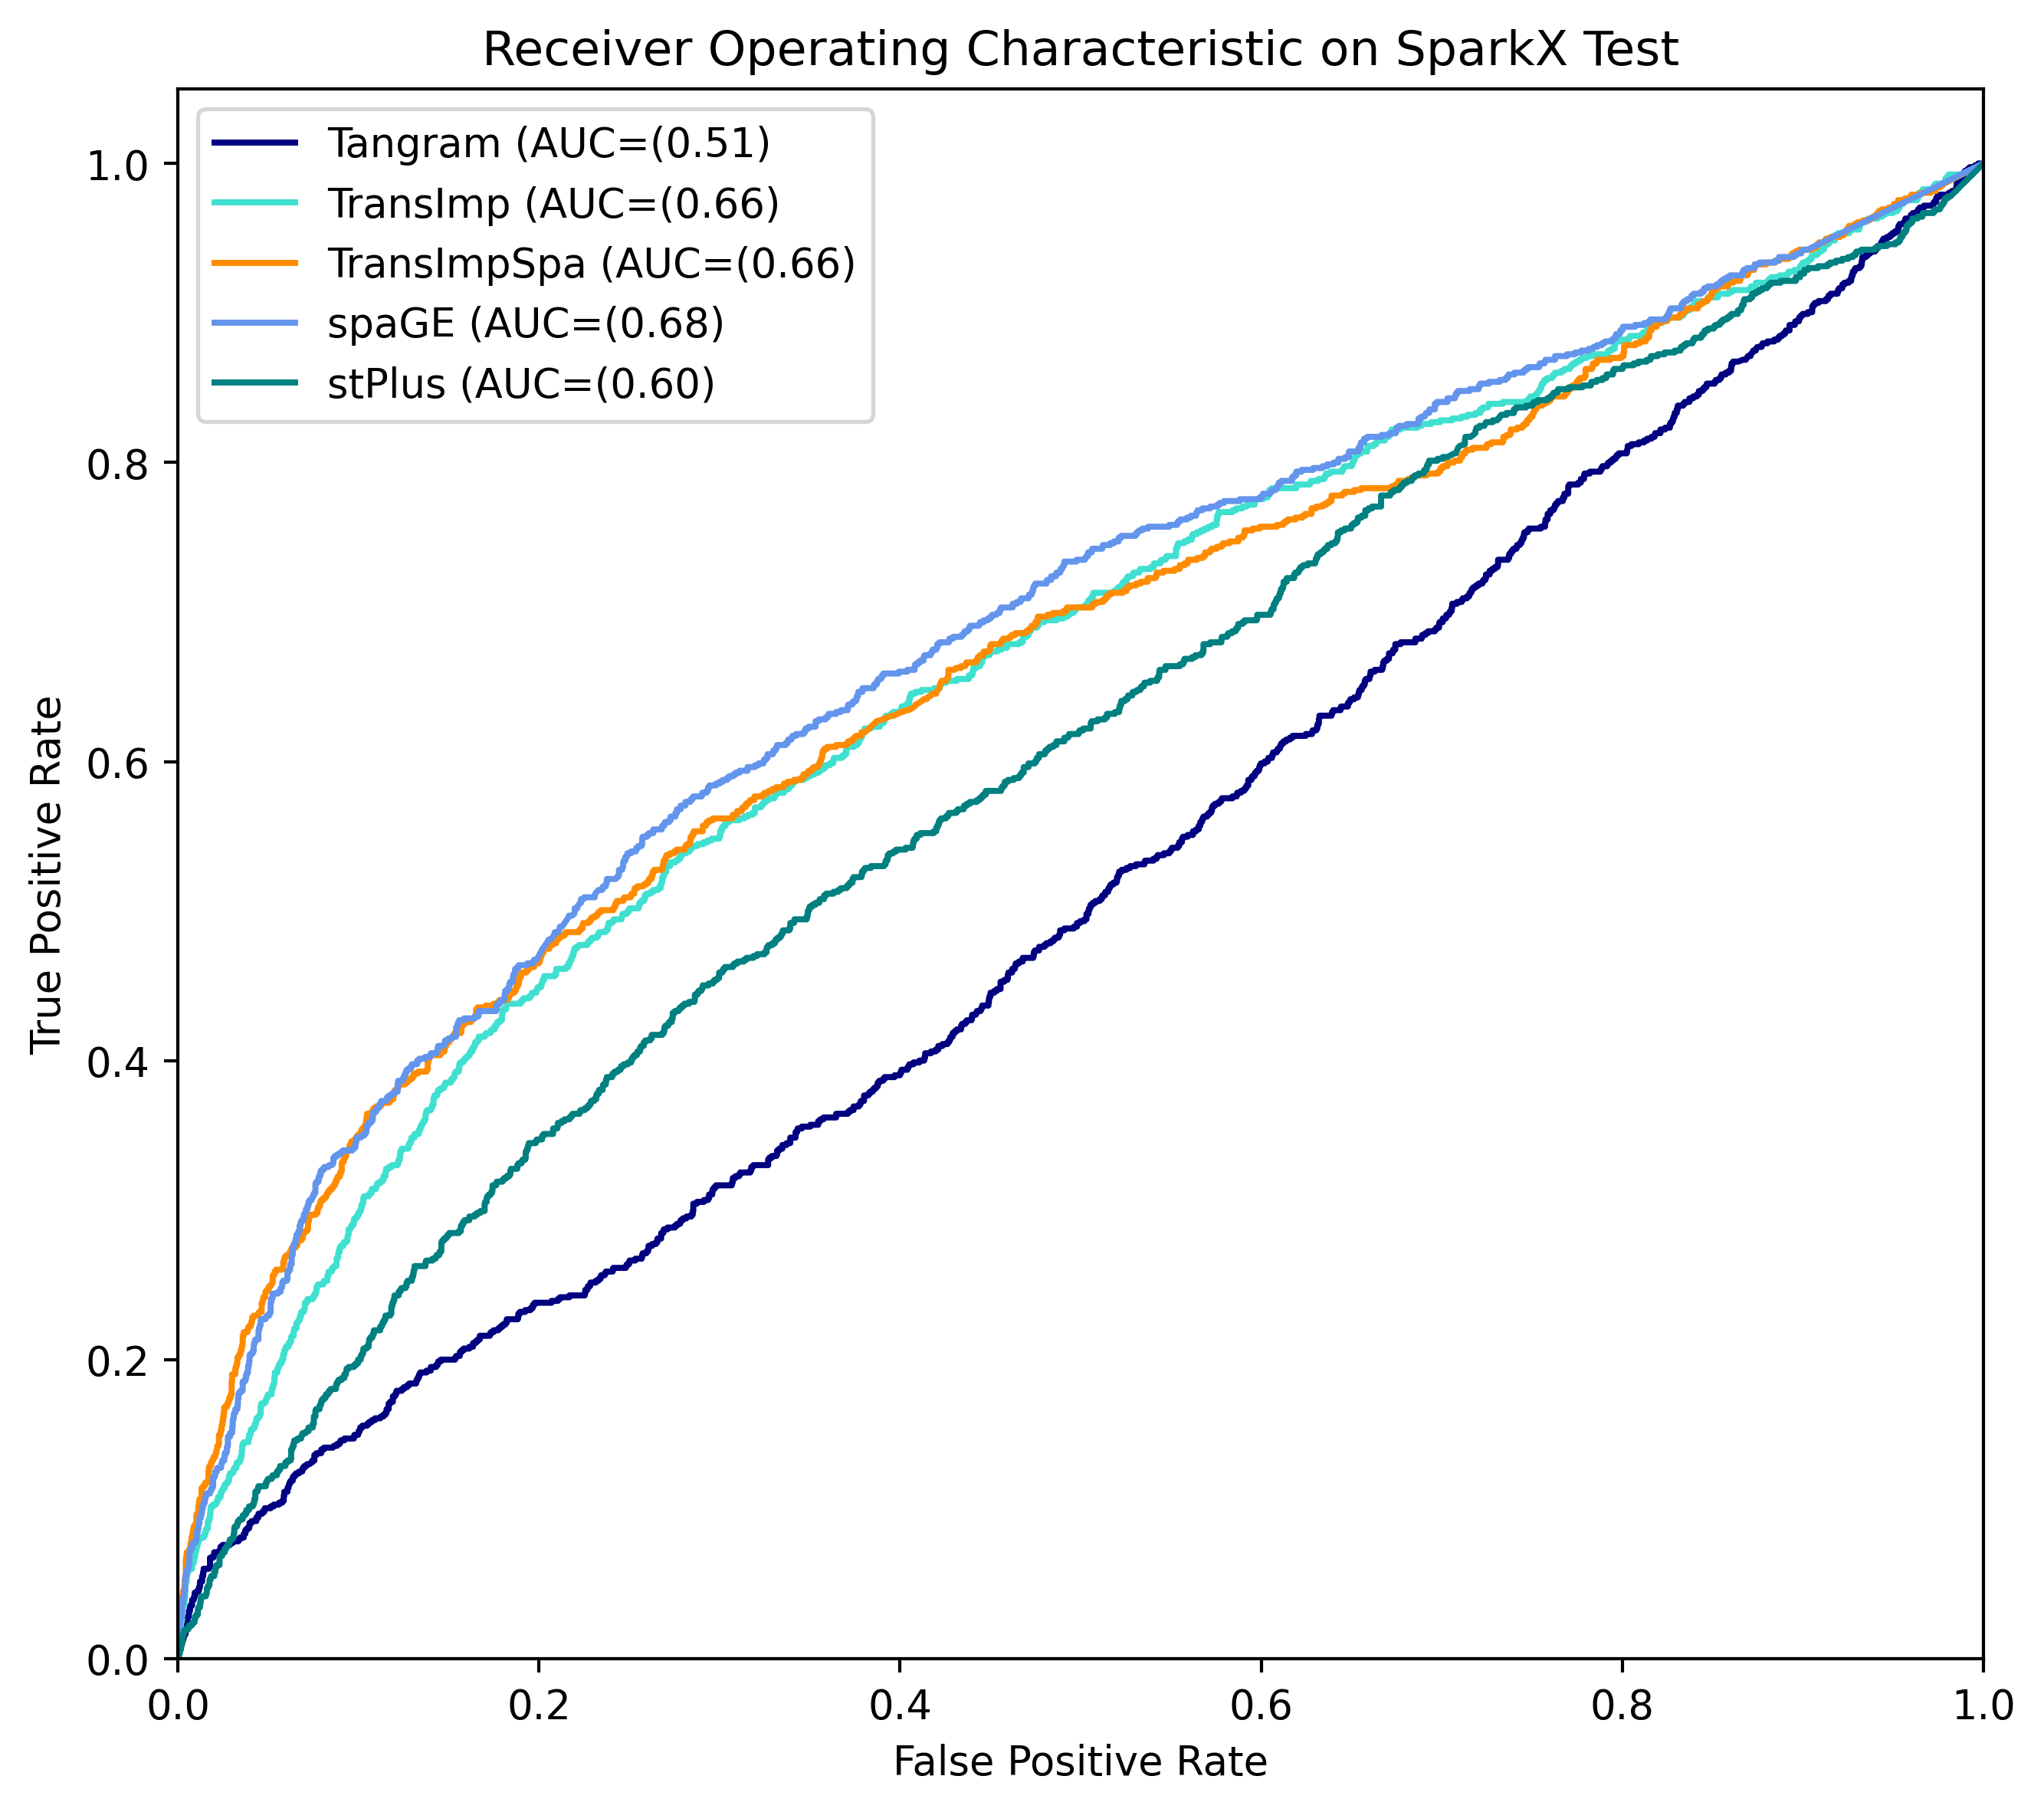

In [18]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 4241/4241
Tangram
FPR: 0.985989
prec: 0.19244561319627063, recl: 0.9877300613496932,  F1: 0.32212885154061627
(TransImp) Valid genes: 4241/4241
TransImp
FPR: 0.958260
prec: 0.19494850416871015, recl: 0.9754601226993865,  F1: 0.32495401594114043
(TransImpCls) Valid genes: 4241/4241
TransImpCls
FPR: 0.990368
prec: 0.19271948608137046, recl: 0.9938650306748467,  F1: 0.3228377839776803
(TransImpClsSpa) Valid genes: 4241/4241
TransImpClsSpa
FPR: 0.978109
prec: 0.19330765527202695, recl: 0.9852760736196319,  F1: 0.3232038639565305
(TransImpSpa) Valid genes: 4241/4241
TransImpSpa
FPR: 0.903678
prec: 0.19875776397515527, recl: 0.9423312883435583,  F1: 0.32827527249412264
(spaGE) Valid genes: 4241/4241
spaGE
FPR: 0.706947
prec: 0.2209713734319717, recl: 0.8429447852760736,  F1: 0.35015290519877684
(stPlus) Valid genes: 4241/4241
stPlus
FPR: 0.950963
prec: 0.1913626209977662, recl: 0.9460122699386503,  F1: 0.3183319570602807


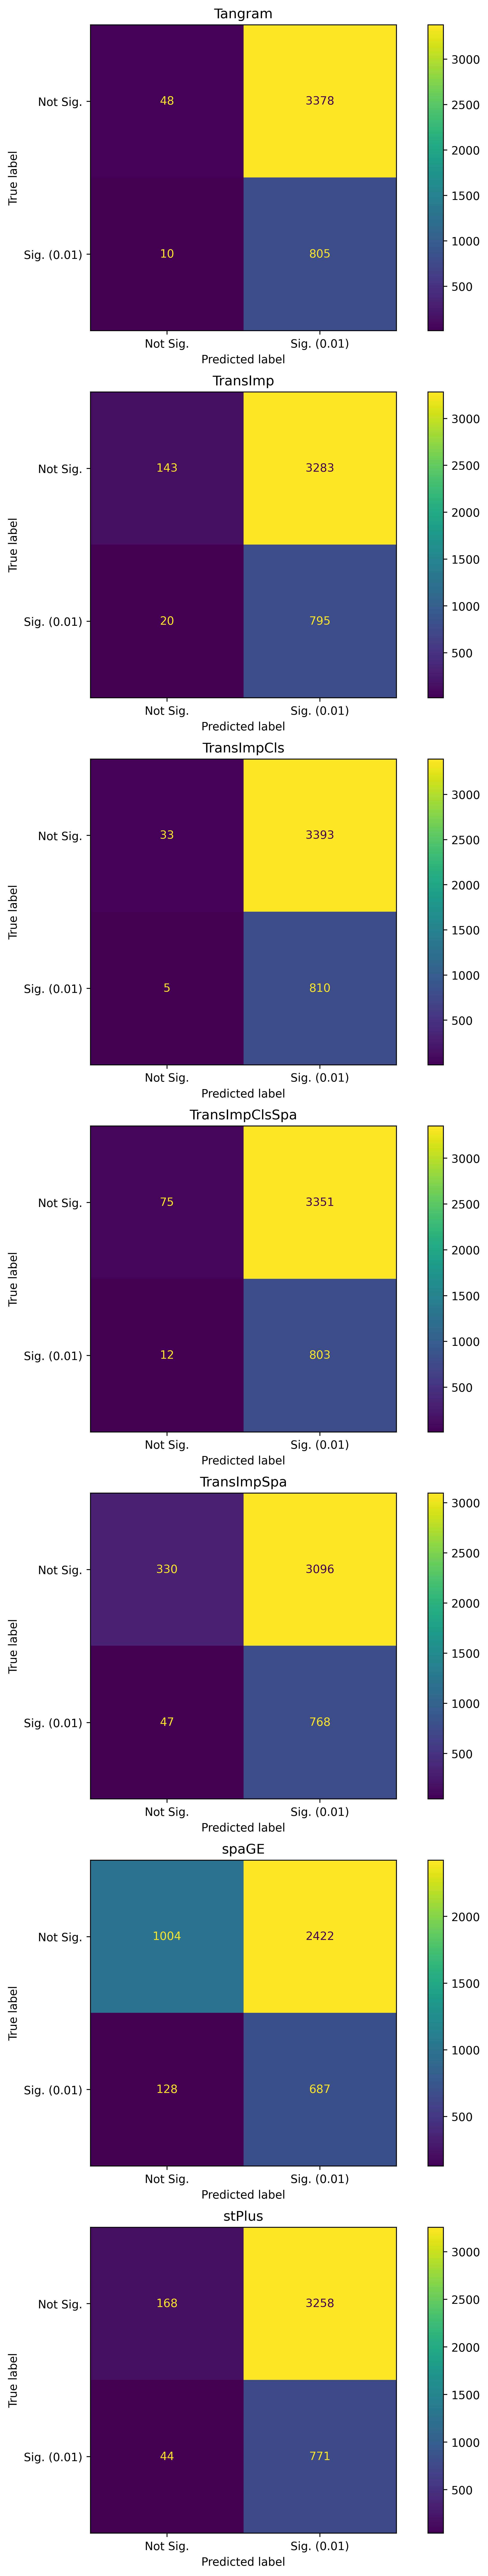

In [19]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [20]:
from scipy import sparse
def merge_data(imp_adata, adata):
    valid_genes = [g for g in adata.var_names if g not in imp_adata.var_names]
    print(f"Valid genes: {len(valid_genes)}, Ex genes: {imp_adata.shape[1]}")
    X = adata[:, valid_genes].X
    if sparse.issparse(X):
        X = X.toarray()
    X = np.hstack([X, imp_adata.X])
    m_adata = sc.AnnData(X, dtype=np.float32)
    m_adata.var_names = np.concatenate([valid_genes, imp_adata.var_names.values])
    return m_adata
def read_data(imp_adatas):
    spa_adata = sc.read_mtx("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/matrix.mtx").T
    spa_adata.var_names = pd.read_csv("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/features.tsv", header=None).iloc[:, 0].values
    spa_adata.obs_names = pd.read_csv("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/barcodes.tsv", header=None).iloc[:, 0].values
    df_loc = pd.read_csv("../../data/ST/BreastCancer/spatial/1142243F_spatial/tissue_positions_list.csv", header=None, index_col=0).loc[spa_adata.obs_names]
    spa_adata.obs['In_tissue'] = df_loc.iloc[:, 0]
    spa_adata.obs['array_row'] = df_loc.iloc[:, 1]
    spa_adata.obs['array_col'] = df_loc.iloc[:, 2]
    spa_adata.obs['px_row'] = df_loc.iloc[:, 3]
    spa_adata.obs['px_col'] = df_loc.iloc[:, 4]
    spa_adata.obsm['spatial'] = spa_adata.obs[['px_row', 'px_col']].values
    adatas = {}
    for method in methods:
        adatas[method] = merge_data(imp_adatas[method], spa_adata)
        adatas[method].obsm['spatial'] = spa_adata.obsm['spatial'].copy()
    return adatas

m_adatas = read_data(dict_adata)

Valid genes: 24161, Ex genes: 4241
Valid genes: 24161, Ex genes: 4241
Valid genes: 24161, Ex genes: 4241
Valid genes: 24161, Ex genes: 4241
Valid genes: 24161, Ex genes: 4241
Valid genes: 24161, Ex genes: 4241
Valid genes: 24161, Ex genes: 4241
Valid genes: 24161, Ex genes: 4241


In [30]:
def spatialdm(adata, spec, l):
    sdm.weight_matrix(adata, n_nearest_neighbors=6, l=l, cutoff=0.2, single_cell=False)
    # find overlapping LRs from CellChatDB
    sdm.extract_lr(adata, spec, min_cell=3)
    # global Moran selection
    # print(adata.uns)
    # print(adata)
    cp_adata = None
    try:
        sdm.spatialdm_global(adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)        
    except Exception as e:
        # print(e)
        cp_adata = adata.copy()
        sdm.extract_lr(cp_adata, spec, min_cell=1)
        sdm.spatialdm_global(cp_adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(cp_adata, method='z-score', fdr=True, threshold=0.1)
    # select significant pairs
    if not cp_adata is None:
        full_set = adata.uns['geneInter'].interaction_name
        # print(np.intersect1d(full_set, cp_adata.uns['global_res'].index.values))
        full_global_res = cp_adata.uns['global_res'].copy()
        full_global_res['global_I'] = cp_adata.uns['global_I'].copy()
        for pair in full_set:
            if pair not in cp_adata.uns['global_res'].index.values:
                # z	perm_pval	fdr	selected
                full_global_res = pd.concat([full_global_res, pd.DataFrame({
                    "Ligand0":{pair:pair.split("_")[0]},
                    "Receptor0":{pair:pair.split("_")[1]},
                    "Receptor1":{pair:None},
                    "z_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "z":{pair:np.random.rand()*0.01},
                    "perm_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "fdr":{pair:0.99 + np.random.rand() * 0.01},
                    "selected":{pair:False},
                    "global_I":{pair:np.random.rand() * 1e-6},
                })])
        # print(np.intersect1d(full_global_res.index, cp_adata.uns['global_res'].index.values))        
        adata.uns['global_res'] = full_global_res.loc[adata.uns['geneInter'].interaction_name].copy()
        adata.uns['global_I'] = full_global_res.global_I.values
        
        
    valid_genes = [True if l != r else False for l,r in zip(adata.uns['global_res'].Ligand0, adata.uns['global_res'].Receptor0)]
    print(len(valid_genes), adata.uns['global_res'].shape[0])
    sel = adata.uns['global_res'].index[valid_genes]
    adata.uns['global_res'] = adata.uns['global_res'].loc[sel]
    adata.uns['global_I'] = adata.uns['global_I'][valid_genes]
    adata.uns['global_res'].sort_values(by='fdr')
    print(adata.uns['global_res'].shape)
for md in m_adatas:
    spatialdm(m_adatas[md], spec, 20)    

100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


1638 1638
(1616, 12)


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


1638 1638
(1616, 12)


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


1638 1638
(1616, 12)


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


1638 1638
(1616, 12)


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


1638 1638
(1616, 12)


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


1626 1626
(1604, 12)


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


1638 1638
(1616, 12)


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

1638 1638
(1616, 12)


In [31]:
import pickle
with open(f"../../output/{ST_name}_spatialdm.pkl", 'wb') as outfile:
    pickle.dump(m_adatas, outfile)

Tangram # 869 pairs, # sig pairs: (Truth): 289, (Preds) 710
TransImp # 869 pairs, # sig pairs: (Truth): 289, (Preds) 639
TransImpSpa # 869 pairs, # sig pairs: (Truth): 289, (Preds) 611
spaGE # 869 pairs, # sig pairs: (Truth): 289, (Preds) 471
stPlus # 860 pairs, # sig pairs: (Truth): 286, (Preds) 431
stPlus Fewer genes than truth: 860 vs 869
TransImpCls # 869 pairs, # sig pairs: (Truth): 289, (Preds) 654
TransImpClsSpa # 869 pairs, # sig pairs: (Truth): 289, (Preds) 636


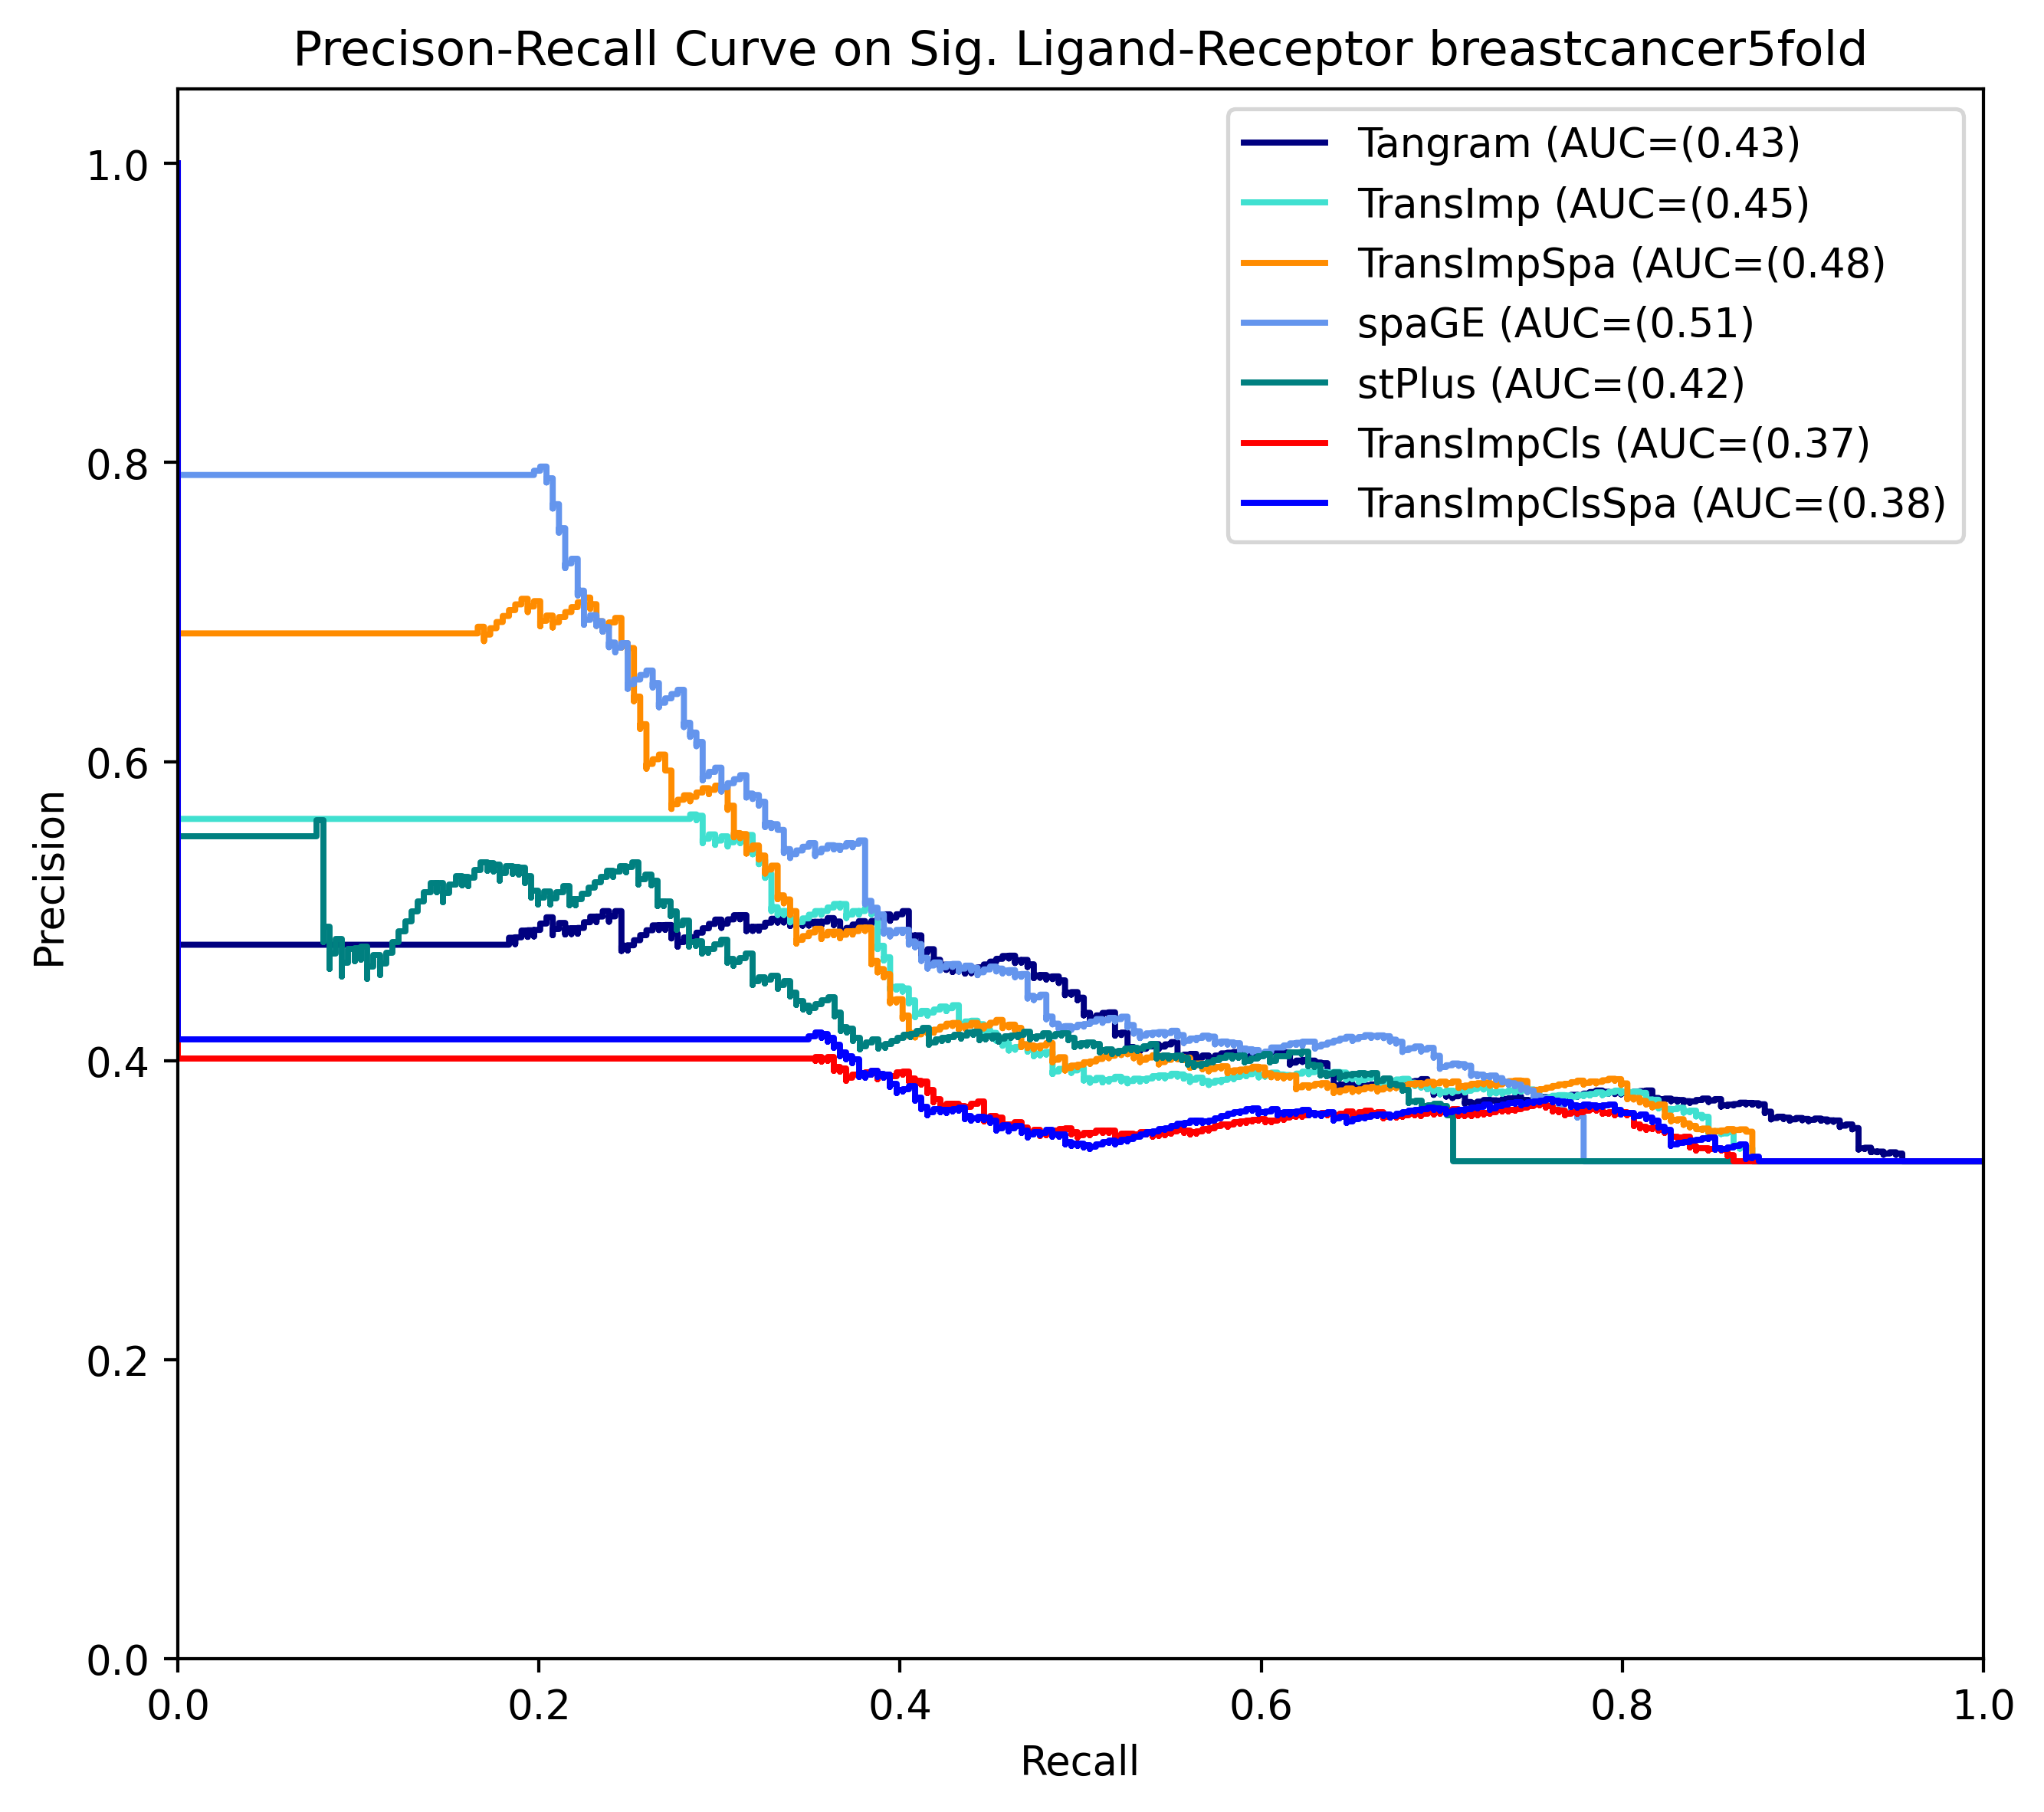

stPlus Fewer genes than truth: 860 vs 869


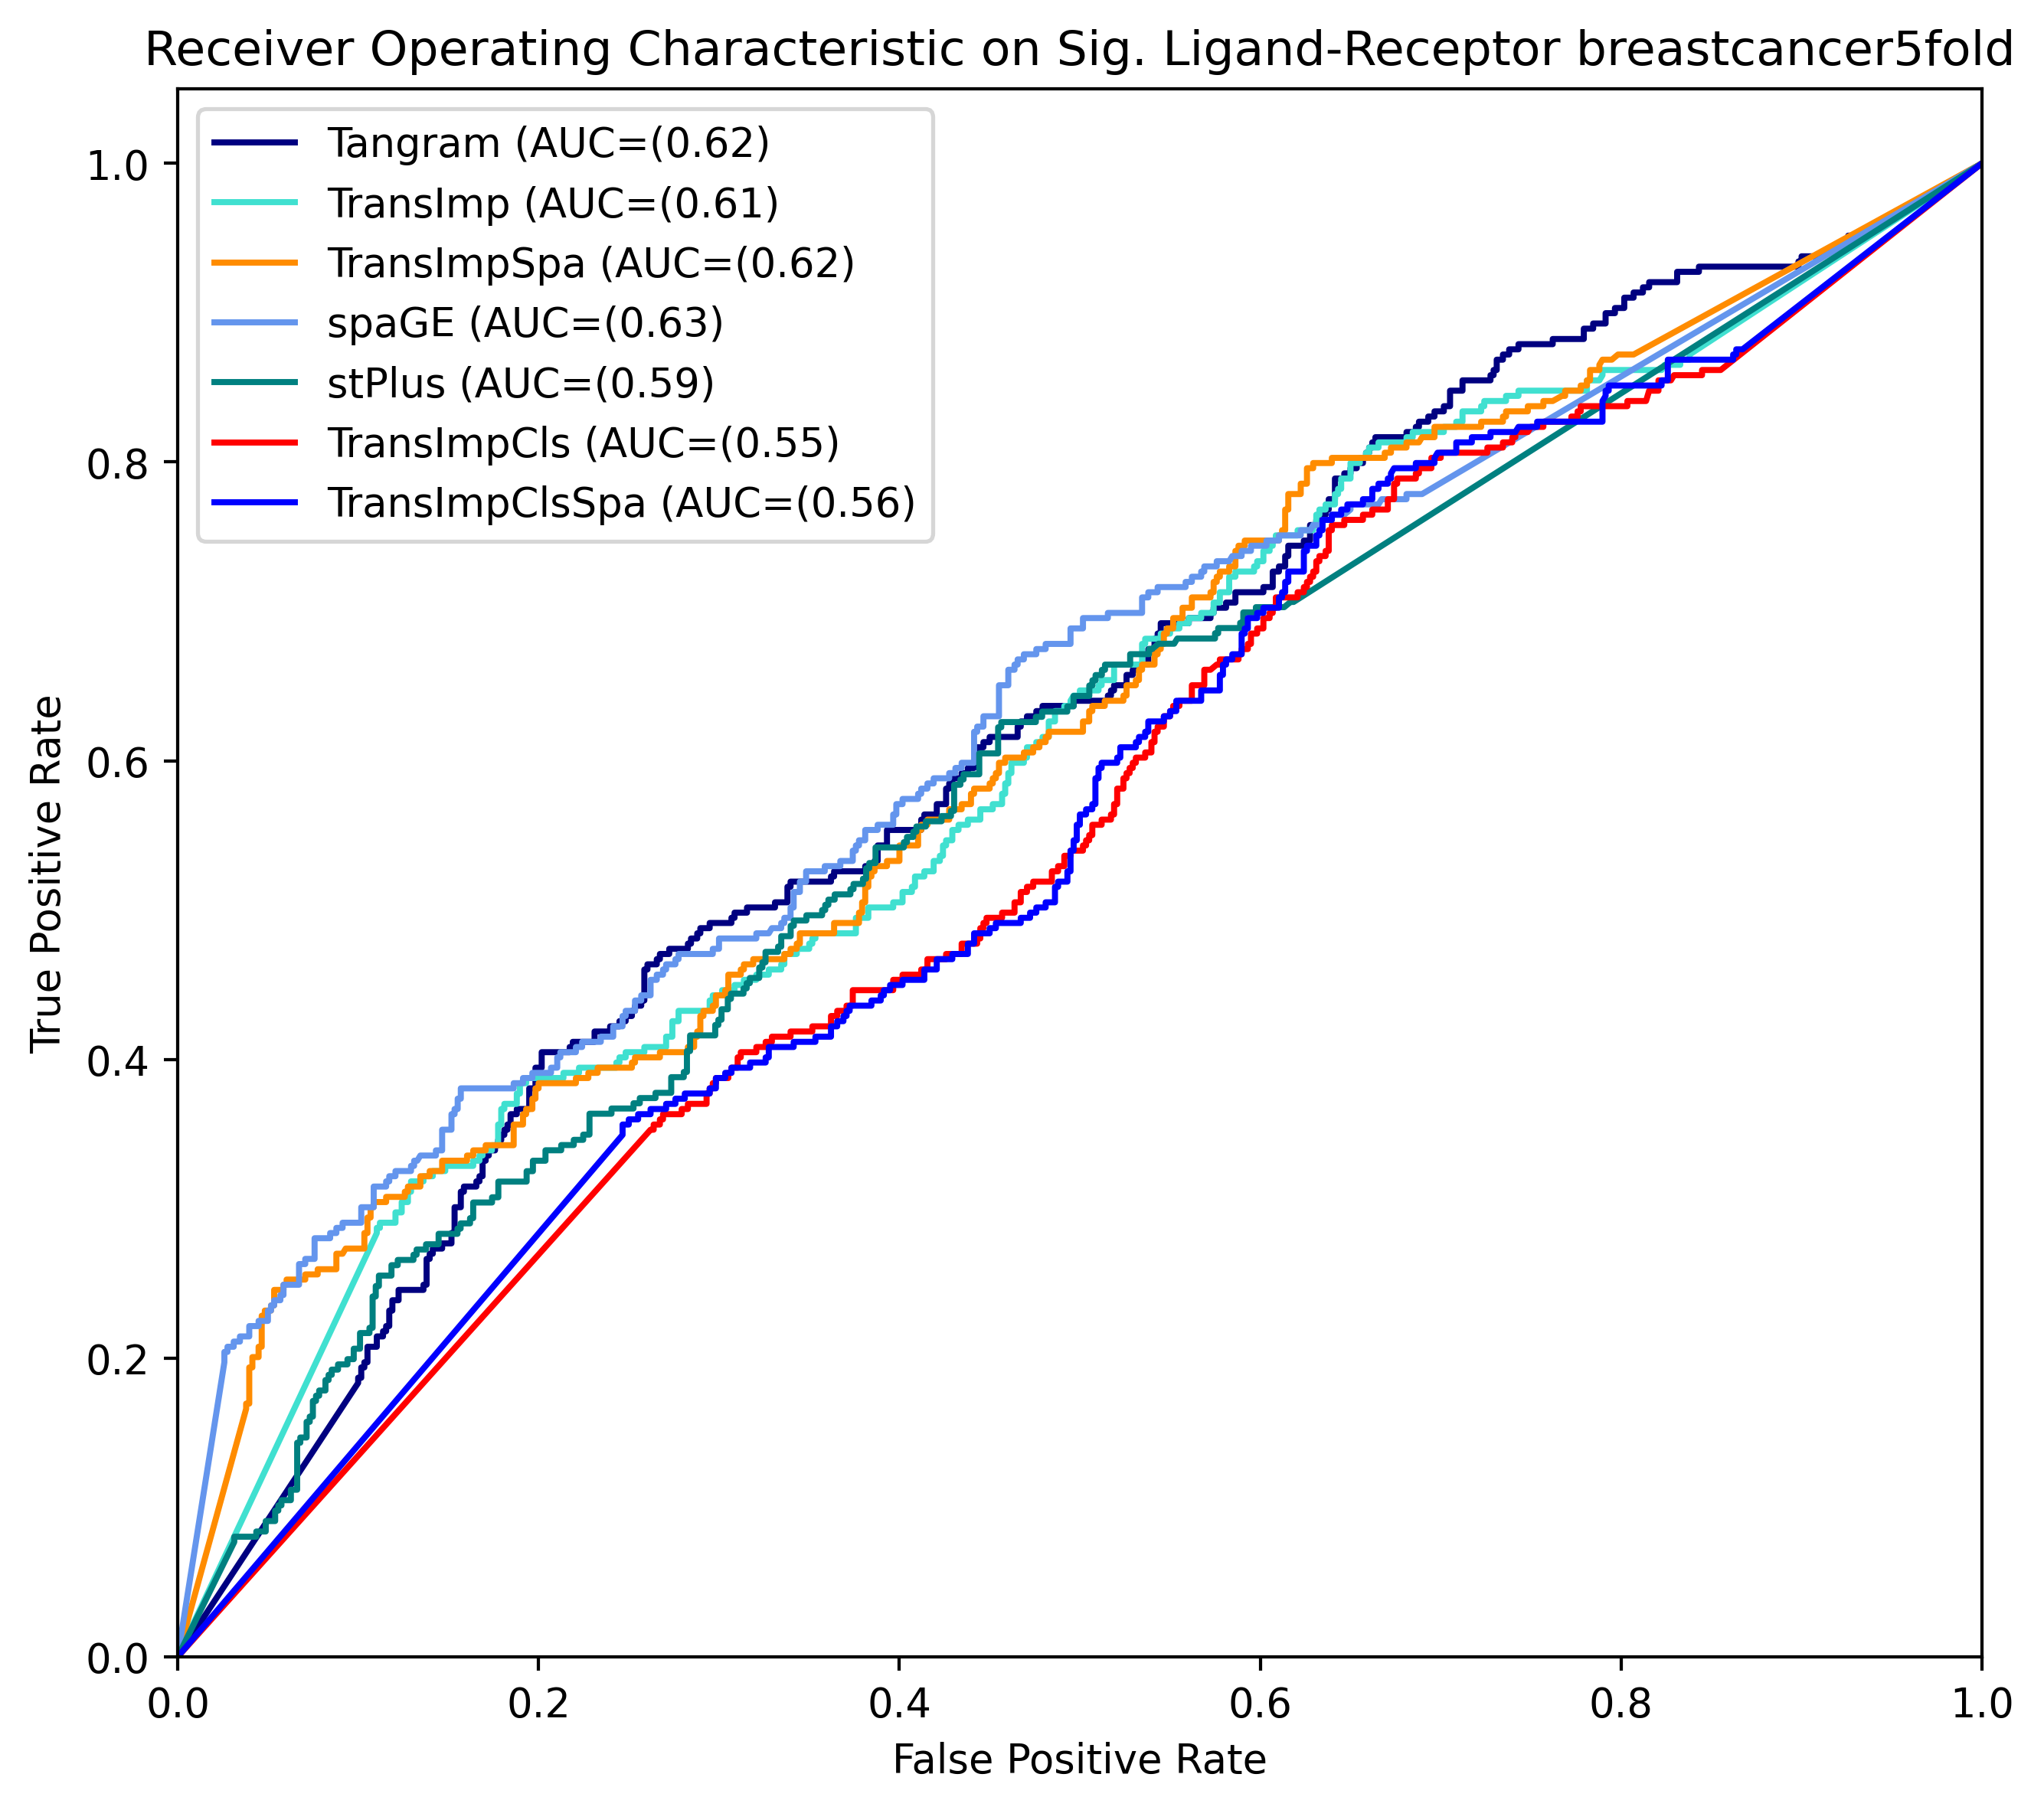

In [32]:
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        print(f"{md} # {len(genes)} pairs, # sig pairs: (Truth): {truth_res.loc[genes].selected.values.sum()}, (Preds) {adatas[md].uns['global_res'].loc[genes].selected.values.sum()}")
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(adatas[md].uns['global_res'].loc[genes].fdr.values)
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # plt.hist(score, bins=100);plt.show()
        # score = expit(score)
        # plt.hist(score, bins=100)
        # plt.show()
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # score = expit(score)
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    

precision_recall_curve(m_adatas, ST_name)
roc_curve(m_adatas, ST_name)
